In [8]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

## Installations and imports

In [9]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [10]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [11]:
import math
import os
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight


from utils import util_data, util_models, util_plot

In [12]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

## Load the dataset

Laod the processed dataset from the repository.

In [13]:
df_train = pd.read_csv("data/model/best_train.csv")
df_test = pd.read_csv("data/model/best_test.csv")

df_train.head(3)

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,2.0,1.792374,1.464186,1.154615,1.401177,1.593219,2.053336,1,1,0,0,1,1,0,0,1.0,2.0,0.0,3.0
1,0.0,-0.010037,-0.634851,-0.393847,-0.472407,0.171458,0.360172,1,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
2,1.0,1.401177,1.811457,0.616541,1.401177,0.846279,1.033647,0,1,0,1,1,0,0,0,1.0,2.0,0.0,2.0


The dataset doesn't contain duplicates, and it is already preprocessed.

In [14]:
# Show duplicated rows
def get_dup_rows(df, drop_cols):
    dup_rows = df[df.duplicated(subset=df.columns.drop(drop_cols), keep=False)]
    return dup_rows

get_dup_rows(df_train, ["misc_price"])

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution


The dataset doesn't contain null values. The total number of rows is n (TODO: write at the end of the work), splitted in training and test datasets.

In [15]:
print(f"Null values:{df_train.isna().sum().sum()}")
print(f"Number of duplicated rows: {df_train.duplicated().sum()}")
print(f"Number of rows: {df_train.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1755


In [16]:
util_data.count_frequency_labels(df_train.misc_price).sort_index()

,Frequency,Count
0.0,35.95%,631
1.0,46.44%,815
2.0,17.61%,309


### Train, validation, test split for the model

In [17]:
print(f"Train dataset: {df_train.shape}, Test dataset: {df_test.shape}")

Train dataset: (1755, 19), Test dataset: (440, 19)


In [18]:
X_train_val, y_train_val = df_train.drop("misc_price", axis=1), df_train.misc_price
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

print(f"X_train_val: {X_train_val.shape}, y_train_val: {y_train_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_val: (1755, 18), y_train_val: (1755,)
X_test: (440, 18), y_test: (440,)


In [19]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=rng)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (1404, 18), y_train: (1404,)
X_val: (351, 18), y_val: (351,)


## Models

### Neural network

In [20]:
import torch
from torch.utils.data import DataLoader
import torchsummary

In [21]:
EPOCHS = 100
BATCH_SIZE = 512
LR = 0.01
N_SPLITS = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))
hidden_layers = [128, 128]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class).to(device)
torchsummary.summary(nn_model, (BATCH_SIZE, num_features));

Device: cpu
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512, 128]            2,432
├─ReLU: 1-2                              [-1, 512, 128]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 512, 128]            16,512
├─ReLU: 1-3                              [-1, 512, 128]            --
├─Linear: 1-4                            [-1, 512, 3]              387
Total params: 19,331
Trainable params: 19,331
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.04
Forward/backward pass size (MB): 1.01
Params size (MB): 0.07
Estimated Total Size (MB): 1.12


In [22]:
train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)
# weights = util_models.compute_inverse_class_frequency(y_train.values, device)
weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights = torch.tensor(weights, dtype=torch.float).to(device)

path_save_model = "models/nn_model.pt"

print(f"Train weights: {weights}")

Train weights: tensor([0.9159, 0.7156, 1.9582])


In [23]:
checkpoint = torch.load(path_save_model)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

#### Holdout

In [301]:
train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

losses, accuracies = train_test.train_model(
    train_data,
    val_data,
    EPOCHS,
    BATCH_SIZE,
    LR,
    print_every=1,
    reset_weights=True,
    ce_weights=weights,
    reduce_lr=True,
    name_model=path_save_model,
    max_accuracy=70,
)

max_i, max_acc = np.argmax(accuracies["val"]), np.max(accuracies["val"])
print(f"\nMax accuracy {max_acc:.3f} at epoch {max_i+1}")


Epoch 001: | Loss: 0.99052 | Acc: 40.527 | Val loss: 0.86410 | Acc: 47.293
Epoch 002: | Loss: 0.79699 | Acc: 57.550 | Val loss: 0.76222 | Acc: 61.254
Epoch 003: | Loss: 0.70212 | Acc: 63.177 | Val loss: 0.74543 | Acc: 62.678
Epoch 004: | Loss: 0.66315 | Acc: 65.670 | Val loss: 0.71144 | Acc: 62.108
Epoch 005: | Loss: 0.63619 | Acc: 66.595 | Val loss: 0.73832 | Acc: 64.957
Epoch 006: | Loss: 0.62999 | Acc: 70.370 | Val loss: 0.68607 | Acc: 63.533
Epoch 007: | Loss: 0.61871 | Acc: 68.305 | Val loss: 0.69733 | Acc: 64.103
Epoch 008: | Loss: 0.60047 | Acc: 70.584 | Val loss: 0.67548 | Acc: 64.672
Epoch 009: | Loss: 0.58920 | Acc: 70.085 | Val loss: 0.70655 | Acc: 64.672
Epoch 010: | Loss: 0.58211 | Acc: 71.225 | Val loss: 0.67846 | Acc: 64.672
Epoch 011: | Loss: 0.57632 | Acc: 71.652 | Val loss: 0.69663 | Acc: 64.672
Epoch 012: | Loss: 0.56598 | Acc: 71.652 | Val loss: 0.70344 | Acc: 64.672
Epoch 013: | Loss: 0.55094 | Acc: 73.362 | Val loss: 0.69148 | Acc: 64.103
Epoch 014: | Loss: 0.5358

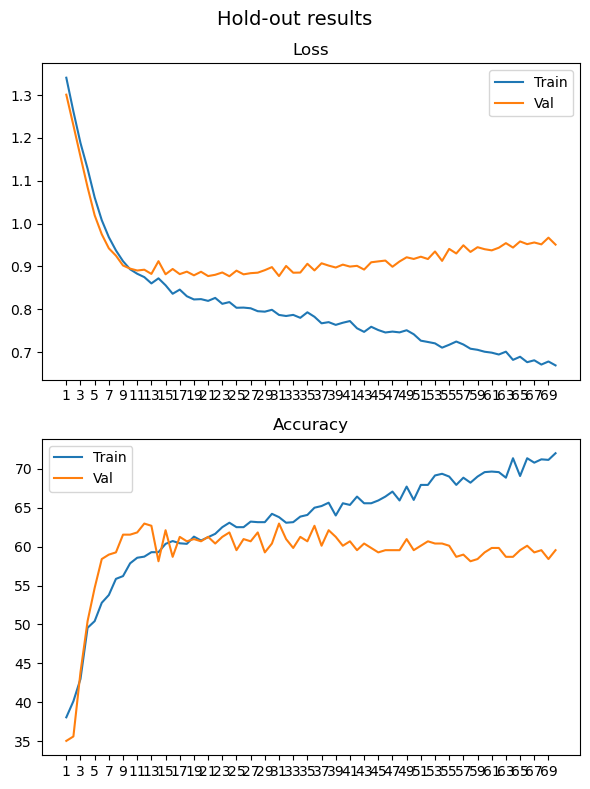

In [ ]:
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")

fig.tight_layout()

#### K-FOLD

In [282]:
EPOCHS = 100
n_losses, n_accuracies = train_test.kfold_train_model(
    X_train_val.values,
    y_train_val.values,
    N_SPLITS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    print_every=5,
    ce_weights=weights,
    reduce_lr=True,
    max_accuracy=70
)

for i, acc in enumerate(n_accuracies):
    max_i, max_acc = np.argmax(acc["val"]), np.max(acc["val"])
    print(f"Fold {i+1}: Max accuracy {max_acc:.2f} at epoch {max_i}")


Epoch 005: | Loss: 0.64418 | Acc: 68.661 | Val loss: 0.74287 | Acc: 64.387
Epoch 010: | Loss: 0.57704 | Acc: 70.584 | Val loss: 0.71382 | Acc: 64.672
Epoch 015: | Loss: 0.52652 | Acc: 74.145 | Val loss: 0.72382 | Acc: 65.242
Epoch 020: | Loss: 0.47673 | Acc: 73.433 | Val loss: 0.77450 | Acc: 69.231
Epoch 025: | Loss: 0.41531 | Acc: 79.843 | Val loss: 0.78770 | Acc: 66.667
Epoch 030: | Loss: 0.36736 | Acc: 82.194 | Val loss: 0.88043 | Acc: 63.818
Epoch 035: | Loss: 0.33178 | Acc: 83.333 | Val loss: 0.92241 | Acc: 66.097
Epoch 00038: reducing learning rate of group 0 to 5.0000e-03.
Epoch 040: | Loss: 0.28613 | Acc: 86.111 | Val loss: 1.00892 | Acc: 67.806
Epoch 045: | Loss: 0.26058 | Acc: 87.607 | Val loss: 1.04276 | Acc: 66.667
Epoch 050: | Loss: 0.26102 | Acc: 86.396 | Val loss: 1.11574 | Acc: 68.091
Epoch 00054: reducing learning rate of group 0 to 2.5000e-03.
Epoch 055: | Loss: 0.23361 | Acc: 88.675 | Val loss: 1.16336 | Acc: 66.952
Epoch 060: | Loss: 0.21616 | Acc: 90.456 | Val loss

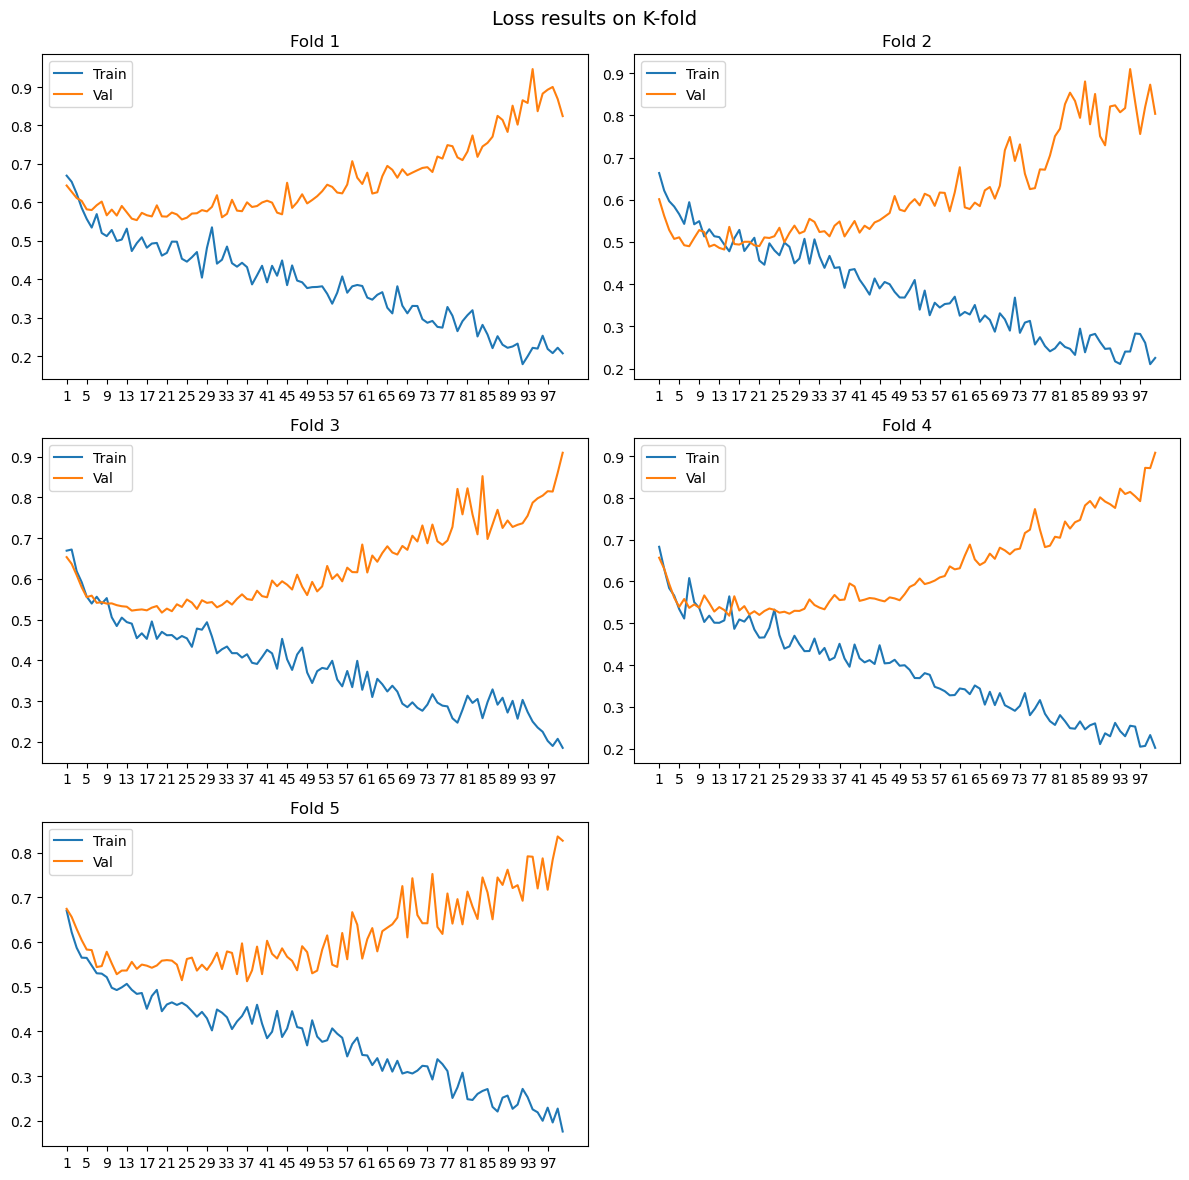

In [211]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.tight_layout()

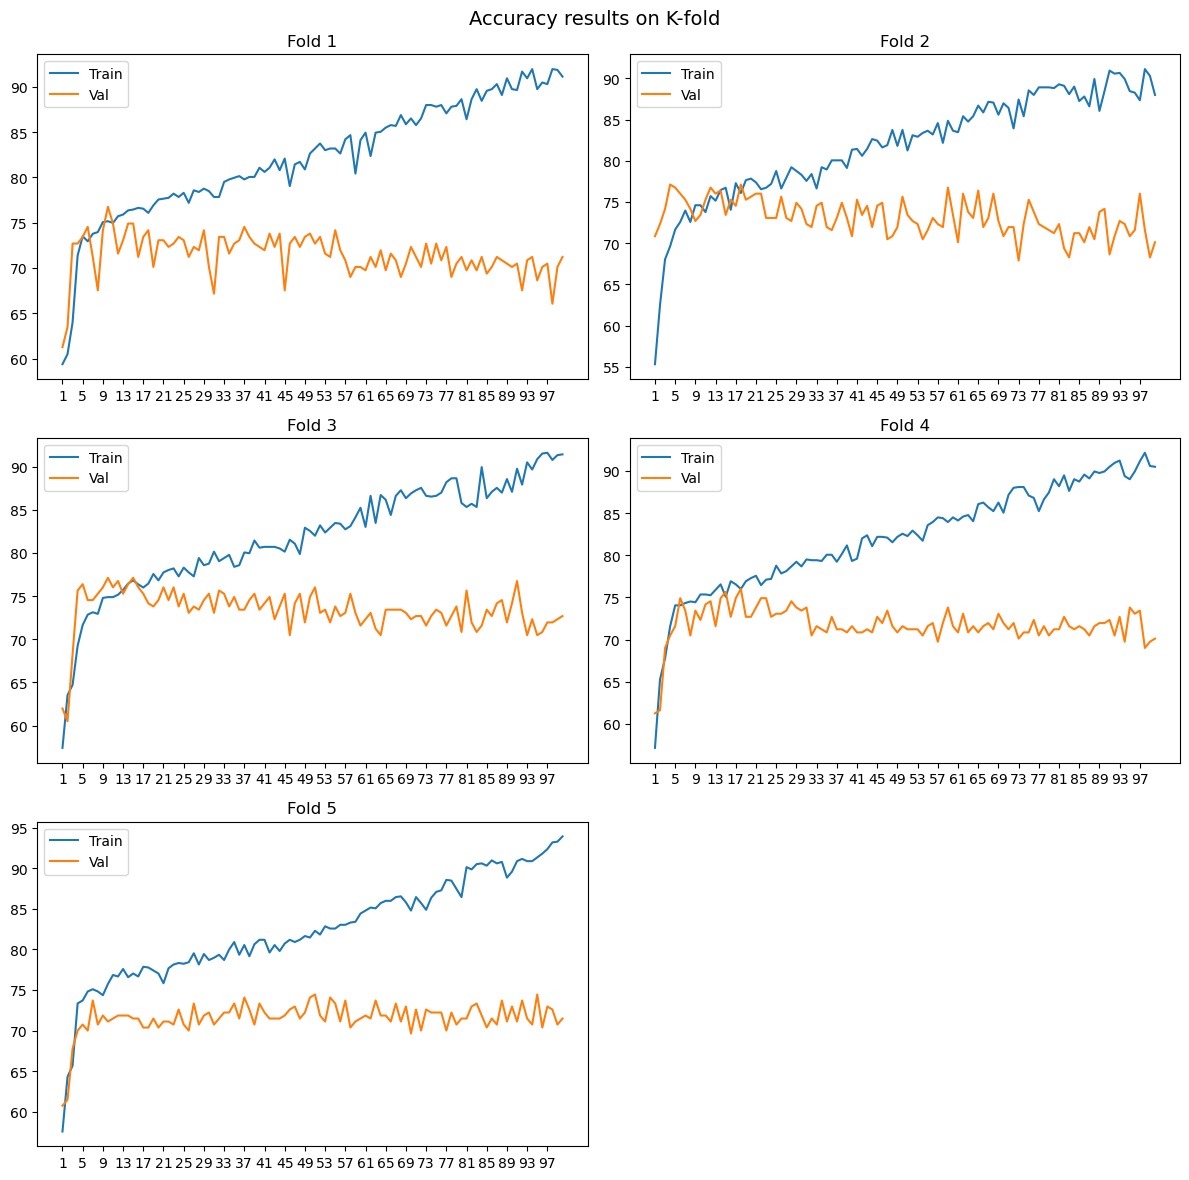

In [213]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

plt.tight_layout()

#### Test the model

In [18]:
y_pred = train_test.test_model(X_test.values, 64)

count_labels, name_labels = [0,1, 2], ["low", "medium", "medium-high"]
print(classification_report(y_test, y_pred, labels=count_labels, target_names=name_labels))

              precision    recall  f1-score   support

         low       0.68      0.75      0.72       156
      medium       0.70      0.64      0.67       207
 medium-high       0.69      0.73      0.71        77

    accuracy                           0.69       440
   macro avg       0.69      0.70      0.70       440
weighted avg       0.69      0.69      0.69       440



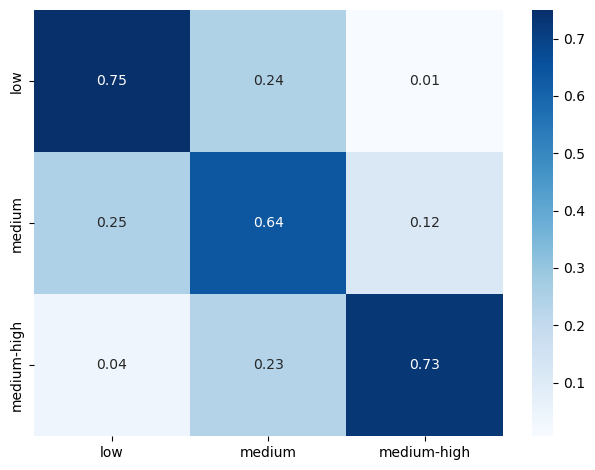

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [20]:
from sklearn.metrics import balanced_accuracy_score

In [21]:
balanced_accuracy_score(y_test, y_pred)

0.7049846288976723

In [23]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


accuracy = evaluate_predictions(y_test, y_pred)
print(f"Accuracy on test: {accuracy:.3f}")

Accuracy on test: 69.318


## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT class (WIP)

In [24]:
from utils import util_counterfactual

import gdown

In [25]:
def evaluate_sample(model, sample_idx):
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        sample_idx = torch.tensor(sample_idx, dtype=torch.float).view(1, -1).to(device)

        # inference and print logits
        y_logit = model(sample_idx)
        print(f"Logits: {y_logit.squeeze()}")
        
        # compute softmax
        y_prob = torch.softmax(y_logit, dim=1)
        print(f"Softmax: {y_prob.squeeze()}")

        # print softmax of predicted class
        y_pred = torch.argmax(y_prob, dim=1)
        print(f"Predicted class {y_pred.item()} with probability: {y_prob.squeeze()[y_pred].item():.3f} and logit: {y_logit.squeeze()[y_pred].item():.3f}")

        # marginlal softmax
        marginal_softmax = torch.log(torch.sum(torch.exp(y_logit))) - y_logit.squeeze()[y_pred].item()
        print(f"Marginal softmax: {marginal_softmax:.3f}\n")

    return y_pred.item()

A marginal softmax computation is performed to compute the probability of the target class with log-linear complexity. However, instead of giving a probability distribution over the target class, it is more similar to a loss, which is minimized.

The minimum value of the marginal softmax for misclassified samples is approximately 0.70, thus a threshold of 0.70 or lower is used to find the counterfactuals.

Number of samples 1404
Minimum value of misclassified samples: 0.705


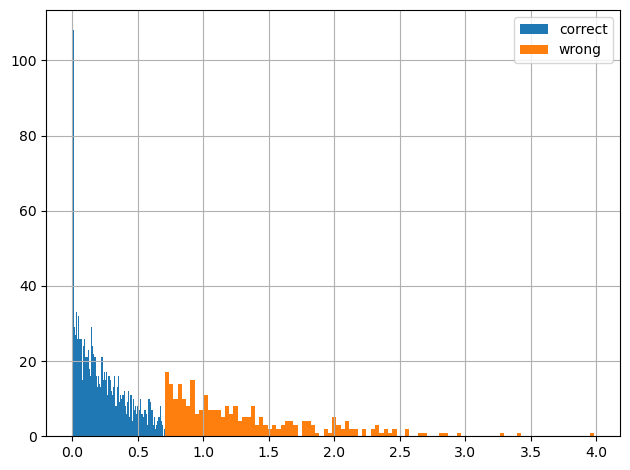

In [44]:
def difference_log_softmax(model, X, y, device):
    print(f"Number of samples {X.shape[0]}")
    model.eval()
    with torch.no_grad():
        correct_diff = []
        wrong_diff = []
        for i in range(X.shape[0]):
            X_i = torch.tensor(X[i], dtype=torch.float).view(1, -1).to(device)
            y_i = round(y[i])

            output = model(X_i)
            y_prob = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_prob, dim=1).item()

            marginal_softmax = torch.log(torch.sum(torch.exp(output))) - output.squeeze()[y_i].item()

            if y_pred == y_i:
                correct_diff.append(marginal_softmax)
            else:
                wrong_diff.append(marginal_softmax)


    return np.array(correct_diff), np.array(wrong_diff)

# compute marginal softmax
correct_diff, wrong_diff = difference_log_softmax(nn_model, X_train.values, y_train.values, device)
print(f"Minimum value of misclassified samples: {np.min(wrong_diff):.3f}")

# plot histogram
pd.Series(correct_diff).hist(bins=100, label="correct")
pd.Series(wrong_diff).hist(bins=100, label="wrong")
plt.legend()
plt.tight_layout()

Sample of the test set of which we want to find the counterfactuals.

In [26]:
idx = 17
sample_idx = X_test.values[idx]
label_idx = y_test.values[idx]
predict_idx = evaluate_sample(nn_model, sample_idx)

cf_class = util_counterfactual.get_counterfactual_class(label_idx, num_class, lower=True)
print(f"Ground-truth label: {label_idx}")
print(f"Predicted label: {predict_idx}. It is {str(label_idx == predict_idx).upper()} that the ground-truth label is the same as the predicted label")

if not label_idx == predict_idx:
    raise ValueError("The ground-truth label is not the same as the predicted label")

print(f"Counterfactual label: {cf_class}", end="\n\n")

Logits: tensor([-6.1491,  0.2991,  1.9929])
Softmax: tensor([2.4579e-04, 1.5523e-01, 8.4452e-01])
Predicted class 2 with probability: 0.845 and logit: 1.993
Marginal softmax: 0.169

Ground-truth label: 2.0
Predicted label: 2. It is TRUE that the ground-truth label is the same as the predicted label
Counterfactual label: 1



In [21]:
cplex_path = os.path.join("C:\Program Files", "IBM", "ILOG", "CPLEX_Studio221", "cplex", "bin", "x64_win64", "cplex.exe")
ipopt_path = os.path.join("C:\\Users", "andre", "ipopt", "bin", "ipopt.exe")

In [243]:
# continuous_feat = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
continuous_feat = X_train.columns.to_list()
solver_options = {"timelimit": 120}

omlt_count = util_counterfactual.OmltCounterfactual(X_train, y_train, nn_model, continuous_feat=continuous_feat)
min_probability = 0.5
cf = omlt_count.generate_counterfactuals(sample_idx, 
                                         cf_class, 
                                         min_probability, 
                                         obj_weights=[0, 1, 0], 
                                         solver_options=solver_options,
                                         verbose=True)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Objective 3 is set to 0, so the distance from the original sample will be 0


Starting MindtPy version 0.1.0 using OA algorithm
iteration_limit: 50
stalling_limit: 15
time_limit: 120
strategy: OA
add_regularization: None
call_after_main_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x00000179AD433460>
call_after_subproblem_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x00000179AD433490>
call_after_subproblem_feasible: <pyomo.contrib.gdpopt.util._DoNothing object at 0x00000179AD4334C0>
tee: true
logger: <Logger pyomo.contrib.mindtpy (INFO)>
logging_level: 20
integer_to_binary: false
add_no_good_cuts: false
use_tabu_list: false
single_tree: false
solution_pool: false
num_solution_iteration: 5
cycling_check: true
feasibility_norm: L_infinity
differentiate_mode: reverse_symbolic
use_mcpp: false
calculate_dual_at_solution: false
use_fbbt: false
use_dual_bound: true
partition_obj_nonlinear_terms: true
quadratic_strategy: 0
move_objective: false
add_cuts_at_incumbent: false
heuristic_nonconvex: false
init_strategy: rNLP
level_coef: 0.5
solution_limit

ERROR: Unable to clone Pyomo component attribute. Component
    'nn.layer[1622318683904].q_relu_index' contains an uncopyable field
    '_init_dimen' (<class 'pyomo.core.base.initializer.ConstantInitializer'>).
    Setting field to `None` on new object
ERROR: Unable to clone Pyomo component attribute. Component
    'nn.layer[1622318683904].q_relu_index' contains an uncopyable field
    '_init_values' (<class 'pyomo.core.base.set.TuplizeValuesInitializer'>).
    Setting field to `None` on new object


         -       Relaxed NLP         0.0128459            inf      0.0128459      nan%      2.61
         1              MILP         0.0128459            inf      0.0128459      nan%      4.27
*        1         Fixed NLP          0.020992       0.020992      0.0128459    38.81%      5.99
         2              MILP         0.0128459       0.020992      0.0128459    38.81%      7.79
*        2         Fixed NLP         0.0130586      0.0130586      0.0128459     1.63%      9.56
         3              MILP         0.0128459      0.0130586      0.0128459     1.63%     12.12
         3         Fixed NLP         0.0183839      0.0130586      0.0128459     1.63%     13.23
         4              MILP         0.0128459      0.0130586      0.0128459     1.63%     15.26
         4         Fixed NLP         0.0140806      0.0130586      0.0128459     1.63%     19.07
         5              MILP         0.0128761      0.0130586      0.0128761     1.40%     25.11
         5         Fixed NLP  

In [244]:
from pyomo.core.base.objective import ScalarObjective
from pyomo.core.base.var import ScalarVar, IndexedVar
from pyomo.core.expr.numeric_expr import DivisionExpression
import pyomo.environ as pyo


def same_softmax(input, n_class):
    exps = [pyo.exp(input[i].value) for i in range(n_class)]
    probs = []
    for exp in exps:
        res = exp/sum(exps)
        probs.append(res)
    return probs

obj_value = omlt_count.pyo_model.obj
# q_relu = omlt_count.pyo_model.obj1_q_relu
# diff_prob = omlt_count.pyo_model.obj1_diff_prob
nn_outputs = omlt_count.pyo_model.nn.outputs
# max_value = omlt_count.pyo_model.obj1_max_val
# softmax_outputs = same_softmax(nn_outputs, n_class=num_class)

isinstance(obj_value, ScalarObjective)
# isinstance(q_relu, ScalarVar)
# isinstance(diff_prob, ScalarVar)
# isinstance(max_value, ScalarVar)
isinstance(nn_outputs, IndexedVar)
# isinstance(softmax_outputs, DivisionExpression)

from pyomo.core.base import value

print(f"Objective value: {value(obj_value)}", end="\n\n")
# print(f"q_relu value: {value(q_relu)}", end="\n\n")
# print(f"diff_prob value: {value(diff_prob)}", end="\n\n")
print(f"max_value value: {value(max_value)}", end="\n\n")

for i in range(len(nn_outputs)):
    print(f"nn_outputs value {i}: {value(nn_outputs[i])}")
    # print(f"softmax_outputs {i}: {softmax_outputs[i]}")

Objective value: 0.013058608541695514

max_value value: 0

nn_outputs value 0: -4.152188797346582
nn_outputs value 1: -0.7588236113864539
nn_outputs value 2: 2.4401226814768924


In [245]:
omlt_count.pyo_model.pprint()

2 Var Declarations
    obj2_cat_sum : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.0 :     0 : False : False :  Reals
    obj2_cont_sum : Size=1, Index=None
        Key  : Lower : Value               : Upper             : Fixed : Stale : Domain
        None :     0 : 0.23505495375051927 : 686.7946711616842 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (obj2_cat_sum + obj2_cont_sum)/18

2 Constraint Declarations
    obj2_cat_sum_constr : Size=1, Index=None, Active=True
        Key  : Lower : Body         : Upper : Active
        None :   0.0 : obj2_cat_sum :   0.0 :   True
    obj2_cont_sum_constr : Size=1, Index=None, Active=True
        Key  : Lower : Body                                                                                                                                                

In [234]:
sample_idx

array([3.22832483, 1.81145745, 1.15461469, 1.40117696, 1.31595786,
       1.56698962, 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       2.        , 0.        , 2.        ])

In [227]:
print("--Sample output--")
y_pred_orig = evaluate_sample(nn_model, sample_idx)

print("--Counterfactual sample--")
counter_idx = cf.loc[0, :].values
y_pred_count = evaluate_sample(nn_model, counter_idx)

if cf_class != y_pred_count:
    raise ValueError("The counterfactual sample did not change the label of the original sample")

print(f"The predicted class for the original sample is {y_pred_orig}, while the predicted sample for the counterfactual is {y_pred_count}.")
print(f"The counterfactual sample {'DID' if (cf_class == y_pred_count) else 'DID NOT'} change the label of the original sample.")

--Sample output--
Logits: tensor([-6.1491,  0.2991,  1.9929])
Softmax: tensor([2.4579e-04, 1.5523e-01, 8.4452e-01])
Predicted class 2 with probability: 0.845 and logit: 1.993
Marginal softmax: 0.169

--Counterfactual sample--
Logits: tensor([-4.1729, -0.7551,  2.4524])
Softmax: tensor([0.0013, 0.0388, 0.9599])
Predicted class 2 with probability: 0.960 and logit: 2.452
Marginal softmax: 0.041



ValueError: The counterfactual sample did not change the label of the original sample

#### Convert the results with scikit-learn transformers

In [228]:
new_sample = pd.DataFrame(np.array(counter_idx, ndmin=2), columns=X_train_val.columns, index=["Counterfactual"])
orig_sample = pd.DataFrame(sample_idx.reshape(1, -1), columns=X_train_val.columns, index=["Orig sample"])
features_df = pd.concat([new_sample, orig_sample], axis=0)

label_df = pd.Series([cf_class, label_idx], name="misc_price", index=comp_df.index).to_frame()
comp_df = pd.concat([features_df, label_df], axis=1)

In [229]:
def display_transformer(df: pd.DataFrame, df_res: pd.DataFrame, ord=2) -> pd.DataFrame:
    def compute_distance(x, y):
        return np.argmin(np.linalg.norm(x - y, ord=ord, axis=1))

    series_transform = df.apply(lambda x: df_res.index[compute_distance(x, df_res)], axis=1)
    df_transform = pd.DataFrame(series_transform, columns=["display_resolution"])
    assert isinstance(df_transform, pd.DataFrame)
    return df_transform

cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

In [230]:
def get_bin_edges(label: float):
    label = int(label)
    return pd.Series(cols_pipeline.transformers_[0][1][2].bin_edges_.item()[label: label+2], index=["price_min", "price_max"])


def inverse_pipeline(cols_pipeline, samples):
    results = pd.DataFrame()

    for name, p, cols in cols_pipeline.transformers_:
        if name == "pipeline-1":
            bin_edges = samples.misc_price.apply(get_bin_edges)
            exp_edges = p[1].inverse_transform(bin_edges)
            results = pd.concat([results, exp_edges], axis=1)

        elif name == "pipeline-2":
            quantile_inv = p[0].inverse_transform(samples[cols])
            quantile_df = pd.DataFrame(quantile_inv, columns=cols, index=samples.index)
            results = pd.concat([results, quantile_df], axis=1)

        elif name == "pipeline-3":
            results = pd.concat([results, samples[cols]], axis=1)

        elif name == "pipeline-4":
            ordinal_inv = p[0].inverse_transform(samples[cols])
            ordinal_df = pd.DataFrame(ordinal_inv, columns=cols, index=samples.index)
            results = pd.concat([results, ordinal_df], axis=1)

        elif name == "pipeline-5":
            cols = p[1].feature_names_in_
            ordinal_inv = p[1].inverse_transform(samples[cols])
            ordinal_df = pd.DataFrame(ordinal_inv, columns=cols, index=samples.index)
            results = pd.concat([results, ordinal_df], axis=1)

    return results


inverse_pipeline(cols_pipeline, comp_df)

,price_min,price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
Counterfactual,184.060285,375.632818,6.39,4000.0,6.0,64.0,16.0,16.0,0.997356,0.001066,0.996352,0.999987,0.99991,0.994822,-0.005584,0.992438,3G,1.0,1.0,qHD
Orig sample,375.632818,1500.000000,7.20,5000.0,6.0,128.0,40.0,24.0,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,4G,3.0,1.0,FHD


### OMLT

In [29]:
import tempfile

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

import onnx

We need to declare the bounds for the variables that we are considering.

In [30]:
x_test_np = X_test.values
y_test_np = y_test.values

In [41]:
idx = 9
sample_idx = x_test_np[idx]
label_idx = y_test_np[idx]

#define dummy input tensor    
dummy_sample = torch.tensor(x_test_np[idx].reshape((1, -1))).type(torch.float)

# Define input region defined by infinity norm
# epsilon_infty = 5e-1
lb = np.repeat(-1, len(sample_idx))
# lb = np.maximum(-1, sample_idx - epsilon_infty)
ub = np.repeat(1, len(sample_idx))
# ub = np.minimum(1, sample_idx + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(x_test_np.shape[1]):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

In [43]:
print(f"Label of sample {idx} is: {label_idx}")

Label of sample 9 is: 2.0


We also export the torch model to an onnx model using the relative function, then we build the formulation of the model that will be used by OMLT to create the optimization model.

In [42]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    # Export neural network to ONNX
    torch.onnx.export(
        nn_model,
        dummy_sample,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    # Write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    # Load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [44]:
formulation = FullSpaceNNFormulation(network_definition)

We can now encode the neural network in a Pyomo model.

In [45]:
# Create pyomo model
pyo_model = pyo.ConcreteModel()

# Create an OMLT block for the neural network and build its formulation
pyo_model.nn = OmltBlock()
pyo_model.nn.build_formulation(formulation) 

In [121]:
#@title #### Compute the mean probability for the correctly predicted samples
#@markdown Since in the objective function we need to take a range of probabilities for computing
#@markdown the error (and we consider only correctly predicted samples for the counterfactual generation),
#@markdown we compute the mean and minimum value of the probabilities of the correct class.   
def count_correct_pred(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        correct_prob = []
        for ind in range(X_test.shape[0]):
            sample = torch.tensor(X_test.iloc[ind].tolist(), dtype=torch.float).view(1, -1)
            prob_pred = torch.softmax(model(sample), dim=1)

            max_prob = torch.argmax(prob_pred).item()
            if max_prob == y_test.values[ind]:
                correct_prob.append(prob_pred[0, max_prob])
    return torch.tensor(correct_prob)


correct_probs = count_correct_pred(nn_model, X_test, y_test)
print(f"The minimum probability for a correctly predicted sample is {torch.min(correct_probs):.3f}")
print(f"The mean probability for the correctly predicted samples is {torch.mean(correct_probs):.3f}")

The minimum probability for a correctly predicted sample is 0.408
The mean probability for the correctly predicted samples is 0.735


We looked for a multi-objective function and we found this interesting [paper](https://arxiv.org/pdf/2004.11165.pdf) in which the authors proposed different objectives to optimize.

TODO: check the upper bound we set, because 20 may be wrong given that we use the squared difference instead of the absolute value of the difference.

In [46]:
#@title #### Functions to create objectives
def my_softmax(input, n_class, real_class):
    '''
        It returns the probability of the desired class after having computed the
        softmax for the input array.
    '''
    exps = [pyo.exp(input[i]) for i in range(n_class)]
    probs = []
    for exp in exps:
        res = exp/sum(exps)
        probs.append(res)
    return probs[real_class]


def features_constraints(pyo_model, feat_info):
    '''
        Set the bounds and the domain for each features given a dictionary that
        contains the bounds as a tuple, the domain as a pyomo domain and the position
        of the feature in the columns.
    '''
    for feat, info in feat_info.items():
        bounds = info["bounds"]
        domain = info["domain"]
        idx = info["index"]

        pyo_model.nn.inputs[idx].domain = domain
        pyo_model.nn.inputs[idx].bounds = bounds


def create_cat_constraints_obj_2(pyo_model, bounds, idx_cat, sample, feat_network):
    '''
        It creates the sum value for the categorical features of the second 
        objective function.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple(int)
                The lower and upper value for the constraints.
            - idx_cat: list[int]
                The indexes of the categorical features that we need to compare.
            - sample: np.ndarray
                The values for the categorical features of the original sample 
                for which the counterfactual is generated.
            - feat_network: list[int]
                The indexes of the connectivity features for which we need to add
                exclusive or constraints.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, len(idx_cat)))

    pyo_model.b_o2 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o2 = pyo.Var(feat_set, domain=pyo.Integers)
    pyo_model.constr_less_o2 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o2 = pyo.Constraint(feat_set)

    # Limit ohe features (network_connectivity)
    for idx in feat_network:
        pyo_model.nn.inputs[idx].domain = pyo.Binary

    pyo_model.xor_conn = pyo.Constraint()
    pyo_model.xor_conn = sum([pyo_model.nn.inputs[idx] for idx in feat_network]) == 1

    cat_dist = 0
    for i, idx in enumerate(idx_cat):
        pyo_model.diff_o2[i] = (sample[i] - pyo_model.nn.inputs[idx])**2

        pyo_model.constr_less_o2[i] = pyo_model.diff_o2[i] >= (pyo_model.b_o2[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o2[i] = pyo_model.diff_o2[i] <= (pyo_model.b_o2[i]*(U-1) + 1)+1
        cat_dist += pyo_model.b_o2[i]

    return cat_dist


def gower_distance(x, cat, num, ranges, pyo_model, feat_network, feat_info):
    '''
        It computes the Gower distance.

        Parameters: 
            - x: np.ndarray
                The array of features of the original sample.
            - cat: list[int]
                The indexes of the categorical features.
            - num: list[int]
                The indexes of the continuous features.
            - ranges: np.ndarray
                The list of ranges for the continuous features.
            - feat_network: list[int]
                The indexes of the positions of the network connectivity features
                to set exclusive or.
            - feat_info: dict
                It contains the information about the features to set the bounds
                and domain for each one.
    '''
    features_constraints(pyo_model, feat_info)

    num_dist = 0
    for i, idx in enumerate(num):
        num_dist += (1/ranges[i])*((x[idx]-pyo_model.nn.inputs[idx])**2)
    
    cat_dist = create_cat_constraints_obj_2(pyo_model, (0, 20), cat, x[cat], feat_network)

    return (cat_dist+num_dist)/len(x)


def compute_obj_3(pyo_model, bounds, n_feat, sample):
    '''
        It creates the third objective function, that limits the number of features
        changed during counterfactual.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple[int]
                The bounds to use for the constraints.
            - n_feat: int
                The number of features of the sample.
            - sample: np.ndarray
                The original sample for which the counterfactual is created.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, n_feat))

    pyo_model.b_o3 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o3 = pyo.Var(feat_set, domain=pyo.Reals)
    pyo_model.constr_less_o3 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o3 = pyo.Constraint(feat_set)

    changed = 0
    for i in range(n_feat):
        pyo_model.diff_o3[i] = (sample[i] - pyo_model.nn.inputs[i])**2

        pyo_model.constr_less_o3[i] = pyo_model.diff_o3[i] >= (pyo_model.b_o3[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o3[i] = pyo_model.diff_o3[i] <= (pyo_model.b_o3[i]*(U-1) + 1)+1
        changed += pyo_model.b_o3[i]

    return changed



def get_counterfactual_class(initial_class, num_classes, lower=True):
    """
        It returns the counterfactual class given the initial class, the number
        of classes and if the counterfactual needs to be lower or higher. The 
        function considers only counterfactuals that differs by 1 from the original
        class.
    """ 
    if initial_class >= num_classes or initial_class < 0:
        print("ERROR: the initial class has not a valid value.")
        return None
    initial_class = round(initial_class)
    idx_check = 0 if lower else num_classes - 1
    counterfactual_op = -1 if lower else 1
    if initial_class == idx_check:
        print("WARNING: the desired value was out of range, hence the opposite operation has been performed.")
        return initial_class - counterfactual_op
    return initial_class + counterfactual_op

We need to restrict the range of values that the categorical features can assume, we set the Integers domain for all the ones that are not binary and we use as bounds the maximum and minimum value of the feature.

In [47]:
def create_feature_pyomo_data(X_test, num_cols):
    feat_info = {}
    binary_var = lambda x: 0 if "camera" in x else 1
    
    categorical_features = X_test.columns[~X_test.columns.isin(num_cols)]
    # Categorical features
    for col in categorical_features:
        feat_info[col] = {}
        if not binary_var(col):
            feat_info[col]["domain"] = pyo.Integers
            # Set the 2 extremes as bounds for the feature
            bounds = tuple(X_test[col].unique()[[0, -1]])
            feat_info[col]["bounds"] = bounds
        else:
            feat_info[col]["domain"] = pyo.Binary
            feat_info[col]["bounds"] = (0, 1)
        feat_info[col]["index"] = X_test.columns.tolist().index(col)

    return feat_info


num_cols = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
feat_info = create_feature_pyomo_data(X_test, num_cols)

In [48]:
cf_class = get_counterfactual_class(label_idx, 4, lower=True)
print(f"Original label: {label_idx}")
print(f"Counterfactual label: {cf_class}")
original_sample = sample_idx

# OBJECTIVE 1
range_prob = 0.51
prob_y = lambda x: my_softmax(x, 4, cf_class)

# something
pyo_model.q_relu = pyo.Var(within=pyo.Binary)
# constraints
pyo_model._z_lower_bound_relu = pyo.Constraint()
pyo_model._z_lower_bound_zhat_relu = pyo.Constraint()
pyo_model._z_upper_bound_relu = pyo.Constraint()
pyo_model._z_upper_bound_zhat_relu = pyo.Constraint()

# set dummy parameters here to avoid warning message from Pyomo
pyo_model._big_m_lb_relu = pyo.Param(default=-1e6, mutable=True)
pyo_model._big_m_ub_relu = pyo.Param(default=1e6, mutable=True)

# define difference of the output
lb, ub = (-1, 1)
pyo_model.diff_prob = pyo.Var(within=pyo.Reals, bounds=(lb, ub), initialize=0)
pyo_model.diff_prob = range_prob - prob_y(pyo_model.nn.outputs)

# define variable for max(0, output)
pyo_model.max_val = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, ub))
pyo_model._big_m_lb_relu = lb
pyo_model._big_m_ub_relu = ub

pyo_model._z_lower_bound_relu = pyo_model.max_val >= 0
pyo_model._z_lower_bound_zhat_relu = pyo_model.max_val >= pyo_model.diff_prob
pyo_model._z_upper_bound_relu= pyo_model.max_val <= pyo_model._big_m_ub_relu * pyo_model.q_relu
pyo_model._z_upper_bound_zhat_relu = pyo_model.max_val <= pyo_model.diff_prob - pyo_model._big_m_lb_relu * (1.0 - pyo_model.q_relu)
#pyo_model.obj_1 = pyo.Objective(expr=pyo_model.max_val)

# ---------------------------------------------------------------- #
# OBJECTIVE 2
# Dataframe with continuous features only
num_df = X_test.loc[:, X_test.columns.isin(num_cols)]
cat_df = X_test.loc[:, ~X_test.columns.isin(num_cols)]
# We need the index of the features to differentiate in the gower distance
idx_cont = [X_test.columns.get_loc(col) for col in num_df.columns]
idx_cat = [X_test.columns.get_loc(col) for col in cat_df.columns]

cont_ranges = (num_df.max() - num_df.min()).values

gower_dist = gower_distance(original_sample, idx_cat, idx_cont, cont_ranges, 
                            pyo_model, [0, 1, 2], feat_info)

# ---------------------------------------------------------------- #

# OBJECTIVE 3
changed_feat_o3 = compute_obj_3(pyo_model, (0, 20), len(original_sample), original_sample)

# Set the objective for the counterfactual as the weighted sum of the three objective functions
pyo_model.obj = pyo.Objective(expr=pyo_model.max_val + 0.4*gower_dist + 0.6*changed_feat_o3)

Original label: 2.0
Counterfactual label: 1


Check what is the expression

In [ ]:
pyo_model.obj.expr.to_string()

'max_val + 0.4*((b_o2[0] + b_o2[1] + b_o2[2] + b_o2[3] + b_o2[4] + b_o2[5] + b_o2[6] + b_o2[7] + b_o2[8] + b_o2[9] + b_o2[10] + b_o2[11] + b_o2[12] + 0.18166679836149016*(1.0566250712265286 - nn.inputs[3])**2 + 0.20023831724820834*(0.5927006978252403 - nn.inputs[4])**2 + 0.2570608104484008*(2.083264950583299 - nn.inputs[5])**2 + 0.21235950364278594*(2.541999626593002 - nn.inputs[6])**2 + 0.10826805044126127*(0.3075974846588067 - nn.inputs[7])**2 + 0.10345063849534261*(0.8256930871634225 - nn.inputs[8])**2 + 0.12588287823187003*(-0.2929567236541104 - nn.inputs[9])**2 + 0.23784756658684886*(-0.06145494365670572 - nn.inputs[10])**2)/21) + 0.4*(b_o3[0] + b_o3[1] + b_o3[2] + b_o3[3] + b_o3[4] + b_o3[5] + b_o3[6] + b_o3[7] + b_o3[8] + b_o3[9] + b_o3[10] + b_o3[11] + b_o3[12] + b_o3[13] + b_o3[14] + b_o3[15] + b_o3[16] + b_o3[17] + b_o3[18] + b_o3[19] + b_o3[20])'

In [ ]:
#@title ### Download cplex from drive and install it
id_cplex_file = "1ePJy9nsNYfkvErFuedT6mbPmTfriQ2e8"
gdown.download(id=id_cplex_file, output="cplex_binary.bin", quiet=False)

# We can use /usr/bin/cplex as installation path when requested
!bash cplex_binary.bin

In [49]:
# If we use as installation folder '/usr/bin'
pyo_solution = pyo.SolverFactory('cplex', executable='/usr/bin/cplex/bin/x86-64_linux/cplex').solve(pyo_model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmp9ii8p38n.cplex.log' open.
CPLEX> Problem '/tmp/tmpe0tnb_1x.pyomo.lp' read.
Read time = 0.02 sec. (0.64 ticks)
CPLEX> Problem name         : /tmp/tmpe0tnb_1x.pyomo.lp
Objective sense      : Minimize
Variables            :    1286  [Nneg: 1,  Box: 817,  Free: 26,  Binary: 428,
                                 General Integer: 14,  Qobj: 6]
Objective nonzeros   :      38
Objective Q nonzeros :       6
Linear constraints   :    2038  [Less: 1215,  Greater: 385,  Equal: 438]
  Nonzeros           :   37864
  RHS nonzeros       :     805

Variables            : Min LB: -259.1161        Max UB

In [ ]:
#@title ### Install cbc solver and run it
!apt-get install -y -qq coinor-cbc
pyo_solution = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(pyo_model, tee=True)

Extract the values of the found sample and test if the label is actually changed as desired.

In [50]:
def evaluate_sample(model, sample_idx):
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        sample_idx = torch.tensor(sample_idx, dtype=torch.float).view(1, -1).to(device)
        # inference
        y_prob = torch.softmax(model(sample_idx), dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

    return y_pred.item()

y_pred_orig = evaluate_sample(nn_model, sample_idx)
counter_idx = list(pyo_model.nn.inputs.get_values().values())
y_pred_count = evaluate_sample(nn_model, counter_idx)

print(f"The predicted class for the original sample is {y_pred_orig}, while the predicted sample for the counterfactual is {y_pred_count}.")

The predicted class for the original sample is 1, while the predicted sample for the counterfactual is 2.


If we print the values of the original sample and the counterfactual we can see that the changes are in the allowed set of values.

In [ ]:
new_sample = pd.DataFrame(np.array(counter_idx, ndmin=2), columns=X_train_val.columns, index=["Counterfactual"])
orig_sample = pd.DataFrame(sample_idx.reshape(1, -1), columns=X_train_val.columns, index=["Orig sample"])
comp_df = pd.concat([new_sample, orig_sample], axis=0)
comp_df

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera
Counterfactual,0.0,0.0,1.0,1.000000,0.592701,1.000000,1.000,0.307597,0.825693,-0.292957,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Orig sample,0.0,1.0,0.0,1.056625,0.592701,2.083265,2.542,0.307597,0.825693,-0.292957,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0


### Dice

In [ ]:
from utils.util_counterfactual import DiceCounterfactual

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [ ]:
df_dice = pd.concat([X_train_val, y_train_val], axis=1)
df_dice.head()

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera,misc_price
1544,0.0,1.0,0.0,-0.369077,-0.486427,1.906789,1.449594,-0.422592,0.186784,-0.347239,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
876,0.0,1.0,0.0,0.839438,-0.118456,0.500206,0.653849,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1339,0.0,1.0,0.0,0.873967,0.776940,-0.906378,-0.619344,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0
1424,0.0,1.0,0.0,-0.455400,-0.486427,-0.906378,-0.778493,0.159890,0.186784,-0.417016,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
287,0.0,1.0,0.0,-0.455400,-0.977055,-0.906378,-0.778493,-0.713833,-0.791101,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


We initialize an instance of the class we created for dealing with Dice and generating counterfactuals.

In [ ]:
cont_features = list(df_dice.columns)
cont_features.remove('misc_price')

dice_cf = DiceCounterfactual(lgb_model.model, 'sklearn', df_dice, cont_features, target="misc_price")

In the first example we only choose one sample, that originally has label 3 (high price) and we want to produce a counterfactual that has label 2 to check which features we can change to decrease the price.

In [ ]:
idx = 40
count_class = 2

orig_sample = df_dice.iloc[[idx]]
orig_sample_lab = df_dice.iloc[[idx]]['misc_price']

We will use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [ ]:
dice_cf.create_explanation_instance(method="genetic")

cfs = dice_cf.generate_counterfactuals(orig_sample, new_class=count_class, target="misc_price", n_cf=2)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


We standardize the original samples and the counterfactuals to get real values for the devices.

In [ ]:
pairs = dice_cf.destandardize_cfs_orig(scaler_num=std_transf)

After that we got the sample - counterfactuals pairs we can pass them to a function in order to compare the differences in the features that allow to classify the sample as the desired class.

In [ ]:
compare_dfs = dice_cf.compare_sample_cf(pairs, color="red")

At the end we can print the comparison for all the samples for which we generated the counterfactuals simply retrieving the dataframe from the list.

In [ ]:
compare_dfs[0]

,Original sample,Counterfactual_0,Counterfactual_1
network_technology_3G,0.000,0.000,0.000
network_technology_4G,1.000,1.000,1.000
network_technology_5G,0.000,0.000,0.000
display_size,6.500,5.500,5.500
battery,3330.000,2730.000,3100.000
display_width,1644.000,1440.000,1440.000
display_height,3840.000,2560.000,960.000
memory_rom_gb,64.000,64.000,64.000
memory_ram_gb,6.000,6.000,6.000
main_camera_resolution,12.000,12.000,12.000


TODO
We can explore different interesting parameters in Dice:
- in 'generate_counterfactuals' function we can use:
    - proximity_weight, diversity_weight;
    - permitted_range, a dictionary with the feature names as keys and a list of the allowed values;
    - features_to_vary;